In [1]:
import ray
import gym, ray
import ray.rllib.agents.ddpg as ddpg
import os
import numpy as np
import pickle
import torch
import argparse
import time
import json
import shutil


from ray import tune
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env
from os import path
from scipy.integrate import solve_ivp
from gym import spaces
from gym.utils import seeding
from functools import partial
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.env.env_context import EnvContext
from ray.tune.registry import register_env
from datetime import datetime

#from custom_functions.custom_functions import env_fn 
#from custom_functions.custom_functions import create_env
#from custom_functions.custom_functions import load_agent
#from custom_functions.custom_functions import test_agent
#from custom_functions.custom_functions import plot_test
#from custom_functions.custom_functions import evaluate_control
#from custom_functions.custom_functions import read_progress




#from GyroEnv0 import GyroscopeEnvV0

/home/xiongyan/anaconda3/envs/gyro_mbrl/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
# 自定义环境 --- Custom environment #

'''
Difference with GyroscopeEnvV0:
-- Gimbal voelocity no longer clipped into [-max velocity, max velocity] range
-- Add several reward functions: exponential, power, sparse, etc...
-- Add a termination condition for sparse reward funciton
'''

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
from ray.tune.registry import register_env


class GyroscopeEnvV1(gym.Env):

    """
    GyroscopeEnv:
        GyroscopeEnv is a GYM environment for Quanser 3-DOF gyroscope. The gyroscope consists of a disk mounted 
        inside an inner gimbal which in turn is mounted inside an outer gimbal.
        The two gimbals are controlled by a RL controller, and the disk is controlled by a PID controller.
    
    State:   # 状态值 --- 7D   都是原始值？？？？？？？
        state = [x1, x2, x3, x4, x1_ref, x3_ref, w] (7 dimensions)   # 状态空间
        Outer red gimbal:   # 外部红色的万向节
            x1, or theta: angular position [rad]   # 角度位置
            x2, or dot(theta): angular velocity [rad/s]   # 角速度
            x1_ref: angular position reference [rad]   # 目标角度位置
            u1: motor voltage [V]   # 电机电压
        Inner blue gimbal:   # 内部蓝色万向节
            x3, or phi: angular position [rad]   # 角度位置
            x4, or dot(phi): angular velocity [rad/s]   # 角速度
            x3_ref: angular position reference [rad]   # 目标角度位置
            u2: motor voltage [V]   # 电机电压
        Golden disk:   # 金黄色转盘
            w: angular velocity [rad/s]   # 角速度
            u3: motor voltage [V]   # 电机电压
        Mechanical constraints:   # 机械约束，参数边界
            motor voltage: [-10, 10] [V]   # 电机电压
            gimbal velocity: [-100, 100] [rpm]   # 万向节转速
            disk velocity: [-300, 300] [rpm]   # 转盘转速
    
    Observation:   # 观测值 --- 9D   所有数字需要归一化？？？？？？？
        observation = [cos(x1), sin(x1), x2, cos(x3), sin(x3), x4, x1_ref, x3_ref, w] (9 dimensions)   # 观测空间
        The angles have been replaced with their cosine and sine to prevent the discontinuity at -pi and pi.
        The observation space is thus larger than the state space.
        
    Action:   # 动作空间
        action = [a1, a2]   # 动作空间
        Note: a1, a2 are normalized voltages   # 归一化电压
              u1, u2 = 10*a1, 10*a2 are actual voltages   # 实际电压指
              T1, T2 = KtotRed*u1, KtotBlue*u2 are motor torques   # 电机扭矩，KtoRed和KtoBlue是电机属性参数
        
    Initialization:   # 初始化
        Some versions of Gym may not support initialization with arguments, so initialize it manully with: 
        # create env   # 创建环境
        env = GyroscopeEnv()
        env.init(simu_args = simu_args, reward_func = reward_func, reward_args = reward_args)
        # simu_args, with optional simulation step (dt), episode length (ep_len), and random seed (seed)   # 仿真三个基本参数
        simu_args = {'dt': 0.05, 'ep_len': 100, 'seed': 2， ‘friction’: False}   # 未考虑摩擦
        # reward_func, optional reward function, default value is 'Quadratic'   # 奖励函数，修改后没有默认值，必须附值
        reward_func = 'Quadratic'
        # reward_args, optional reward parameters  # 用于计算奖励函数的权重参数
        reward_args = {'qx1': 1, 'qx2': 0.01, 'qx3': 1, 'qx4': 0.01, 'pu1': 0, 'pu2': 0}
    """
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Initialization ------------------------------------------ #
    # ---------------------------------------------------------------------------------------------------- #        
                
    def __init__(self, env_config):
        
        # Initialize mechanical parameters of the gyroscope   # 初始化Gyro机械参数
        self.init_gyro()
        
        # Initialize simulation parameters   # 初始化仿真参数
        self.init_simu(**env_config["simu_args"])
        
        # Initialize reward parameters   # 初始化奖励函数参数，用于选择奖励函数类型
        self.init_reward(env_config["reward_func"], env_config["reward_args"])
        
        # State space, 7D   # 状态空间初始化设置
        self.state_bound = np.array([self.maxAngle, self.maxGimbalSpeed, self.maxAngle, self.maxGimbalSpeed, 
                                   self.maxAngle, self.maxAngle, self.maxDiskSpeed], dtype = np.float32)   # 状态空间初始化空间大小，设置最大值
        self.state_space = spaces.Box(low = -self.state_bound, high = self.state_bound, dtype = np.float32)   # 状态空间上下限设置
        
        # Observation space (normalized), 9D   # 观测空间初始化设置（归一化）
        self.observation_bound = np.array([1.0] * 9, dtype = np.float32)   # 观测空间初始化空间大小，设置空间维数 
        self.observation_space = spaces.Box(low = -self.observation_bound, high = self.observation_bound, 
                                            dtype = np.float32)   # 观测空间上下限设置
#         print("self.observation_bound：", self.observation_bound)
#         print("self.observation_space：", self.observation_space)
        
        # Action space (normalized), 2D   # 动作空间（归一化）
        self.action_bound = np.array([1.0] * 2, dtype = np.float32)   # 动作空间设置，设置空间维数大小
        self.action_space = spaces.Box(low = -self.action_bound, high = self.action_bound, dtype = np.float32)   # 动作空间上下限设置
    
    # Initialize fixed parameters of the gyroscope   # 初始化Gyro的特定机械参数
    def init_gyro(self):
        
        # Inertias in Kg*m2, from SP report page 23, table 2   # 设备固定参数
        self.Jrx1 = 0.0179
        self.Jbx1 = 0.0019
        self.Jbx2 = 0.0008
        self.Jbx3 = 0.0012
        self.Jdx1 = 0.0028
        self.Jdx2 = 0.0056
        self.Jdx3 = 0.0056
#         print("Gyro的特定机械参数：")
#         print("self.Jrx1=" + str(self.Jrx1),
#              "self.Jbx1=" + str(self.Jbx1),
#              "self.Jbx2" + str(self.Jbx2),
#              "self.Jbx3" + str(self.Jbx3),
#              "self.Jdx1" + str(self.Jdx1),
#              "self.Jdx2" + str(self.Jdx2),
#              "self.Jdx3" + str(self.Jdx3))
    

        # Combined inertias to simplify equations, from SP report page 22, state space equations   # 状态空间空间方程，组合惯量
        self.J1 = self.Jbx1 - self.Jbx3 + self.Jdx1 - self.Jdx3
        self.J2 = self.Jbx1 + self.Jdx1 + self.Jrx1
        self.J3 = self.Jbx2 + self.Jdx1

        # Motor constants, from SP report page 23, table 1   # 电机参数
        self.Kamp = 0.5 # current gain, A/V   # 电流增益
        self.Ktorque = 0.0704 # motor gain, Nm/A   # 电机增益
        self.eff = 0.86 # motor efficiency   # 电机效率
        self.nRed = 1.5 # red gearbox eatio   # 红色万向节变速箱传动比
        self.nBlue = 1 # blue gearbox eatio   # 蓝色万向节变速箱传动比
        self.KtotRed = self.Kamp * self.Ktorque * self.eff * self.nRed # Nm/V   # 红色万向节扭矩，特定计算公式
        self.KtotBlue = self.Kamp * self.Ktorque * self.eff * self.nBlue # Nm/V   # 蓝色万向节扭矩，特定计算公式
        
        # Mechanical constraints   机械系统约束
        self.maxVoltage = 10 # V   # 最大电压
        self.maxAngle = np.pi # rad   # 最大角度
        self.maxGimbalSpeed = 100 * 2 * np.pi / 60 # rad/s   # 最大万向节转速
        self.maxDiskSpeed = 300 * 2 * np.pi / 60 # rad/s   # 最大转盘转速
#         print("Max speed of Gimbal:", self.maxGimbalSpeed )
#         print("Max speed of Disk:", self.maxDiskSpeed)
        
    # Initialize simulation parameters   # 初始化仿真参数
    def init_simu(self, dt = 0.05, ep_len = 100, seed = 2, friction = False):
        
        # Gyroscope state and observation   # Gyro状态空间与观测值空间
        self.state = np.array([0] * 7)   # Gyro状态空间
        self.observe()   # Gyro观测空间   自动打印出观测空间？？？？？？

        # Time step in s   # 时间步长
        self.dt = dt
        self.eval_per_dt = int(dt / 0.01) # run evaluation every 0.01s   # ??????????????????????????????????
        
        # Episode length and current episode   # 剧集长度，一个epoch由多个episode组成，所有episode运行结束进行一次判断
        self.ep_len = ep_len   # 剧集长度设置
        self.ep_cur = 0   # 当前剧集数
#         print("ep_len：" + str(ep_len))
        
        # Seed for random number generation   # 用于指定随机数生成时所用算法开始的整数值，如果使用相同的seed()值，则每次生成的随即数都相同，如果不设置这个值，则系统根据时间来自己选择这个值，此时每次生成的随机数因时间差异而不同。
        self.seed(seed)
        self.viewer = None
#         print("seed：" + str(seed))
        
        # Friction   摩擦力
        self.fvr = 0.002679 if friction else 0   # 存在选项，如果考虑摩擦，则赋值，如果不考虑摩擦则归零
        self.fcr = 0
        self.fvb = 0.005308 if friction else 0   # 存在选项，如果考虑摩擦，则赋值，如果不考虑摩擦则归零
        self.fcb = 0
        
    # Initialize reward parameters   # 初始化奖励参数，用于定义各类奖励函数的ID，便于调用
    def init_reward(self, reward_func, reward_args):
                
        reward_dict = {
            # continuous reward functions, part one   # 连续奖励函数，part one
            'Quadratic': self.quad_reward,
            'Quadratic with bonus':self.quad_bon_reward,
            'Quadratic with exponential': self.quad_exp_reward,
            'Quadratic with ending penalty': self.quad_end_pen_reward,
            'Quadratic with penalty': self.quad_pen_reward,
            'Absolute': self.abs_reward,
            'Normalized': self.norm_reward,
            'Normalized with bonus': self.norm_bon_reward,
            # continuous reward functions, part two   # 连续奖励函数，part two
            'Power':self.power_reward,
            'Exponential': self.exp_reward,
            'PE': self.power_exp_reward,
            # sparse reward functions   # 稀疏奖励函数
            'Sparse':self.sparse_reward,
            'Sparse with exp': self.sparse_reward_with_exp,
            'Sparse with exp 2': self.sparse_reward_with_exp_2
        }
        if reward_func in ['Sparse']: # 'Sparse with exp'
            self.sparse = True
        else:
            self.sparse = False
        self.reward_func = reward_dict[reward_func]
        self.reward_args = reward_args
#         print("reward_dict[reward_func]:" + str(reward_dict[reward_func]))
#         print("reward_args:" + str(reward_args))

    # ---------------------------------------------------------------------------------------------------- #
    # ----------------------------------------------- Step ----------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    # Simulate the environment fot one step dt   # 计算一个步长(step)的仿真环境，也就是计算了ep_len(100)次
    def step(self, a):
        
        # extract states and actions   # 提取状态值和动作值
        x1, x2, x3, x4, x1_ref, x3_ref, w = self.state   # 状态空间取值
        a1, a2 = a   # 动作空间取值
        u1, u2 = self.maxVoltage * a1, self.maxVoltage * a2   # 输出电压赋值

        # Increment episode   # 递增量，每次递增1
        self.ep_cur += 1
#         print('/'+'-'*42+f'{datetime.now()} 开始训练' + '-'*36 + '\\')
#         print(f"Episode {self.ep_cur}\n >> >> >> >> >> >> >>")
        

        # For quad_end_pen_reward, check if terminal state is reached   # 检查是否达到终止状态
        if self.reward_func == self.quad_end_pen_reward and self.ep_cur == self.ep_len:   # ？？？？？？
            self.reward_args['end_horizon'] = 1   # ？？？？？？？？？？
            
#         print(self.quad_end_pen_reward)   # ???????

        # run simulation for a step   # 跑一个步长的仿真
        results = solve_ivp(   # solve_ivp, 该函数对给定初始值的常微分方程组进行数值积分, https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
                    fun = self.dxdt,    # 调用函数fun(t, y)
                    t_span = (0, self.dt), # solver starts with t = 0 and integrates until it reaches t = self.dt
                    y0 = [x1, x2, x3, x4], # initial state
                    method = 'RK45',   # ODE solver --- Explicit Runge-Kutta method of order 5(4)
                    t_eval = np.linspace(0, self.dt, self.eval_per_dt), # times at which to store the computed solution
                    args = (u1, u2) 
                )
        # print("results:", results)   # 计算了ep_len(100)次，
        
        # evaluated states, each contains eval_per_dt points   # 已评估的状态，每个都包含eval_per_dt点
        x1_eval = results.y[0]
        x2_eval = results.y[1]
        x3_eval = results.y[2]
        x4_eval = results.y[3]
#         print("已评估的状态：")
#         print("x2_eval：" + str(x2_eval))
#         print("x4_eval：" + str(x4_eval))

        # change in velocity, or acceleration   # 速度变化，评估值与状态值之间的变化
        dx2 = x2_eval[-1] - x2
        dx4 = x4_eval[-1] - x4
#         print("万向节转速变化：")
#         print("x2_eval[-1]：" +str(x2_eval[-1]))
#         print("x2：" + str(x2))
#         print("dx2：" + str(dx2))
#         print("x4_eval[-1]：" +str(x4_eval[-1]))
#         print("x4：" + str(x4))
#         print("dx4：" + str(dx4))        
        
        
        # keep only the last evaluation value   # 只保留最后的评估值
        x1 = x1_eval[-1]
        x2 = x2_eval[-1]
        x3 = x3_eval[-1]
        x4 = x4_eval[-1]
#         print("只保留最后的评估值：")
#         print("x2_eval[-1]:" + str(x2_eval[-1]))
#         print("x4_eval[-1]:" + str(x4_eval[-1]))
        
        # Angle error (normalized between pi and -pi to get smallest distance)   # 角度误差（在pi和-pi之间归一化，以得到最小的距离
        x1_diff = self.angle_normalize(x1 - x1_ref)
        x3_diff = self.angle_normalize(x3 - x3_ref)
#         print("角度误差归一化：")
#         print("x1_diff:" + str(x1_diff))
#         print("x3_diff:" + str(x3_diff))
        
        # update state and observation   # 更新状态空间和观测空间，其中的观测空间应该归一化？？？？？？？
        self.state = np.array([x1, x2, x3, x4, x1_ref, x3_ref, w])   # 状态空间
        self.observe()   # 观测空间，自动打印出观测空间？？？？？？
#         print("更新状态空间和观测空间：")
#         print("self.state：" + str(self.state))
#         print("self.observe():" + str(self.observe()))

        # Reward(float), normalized everything in advance
        reward = self.reward_func(x1_diff/self.maxAngle, x3_diff/self.maxAngle, 
                                  x2/self.maxGimbalSpeed, x4/self.maxGimbalSpeed, 
                                  dx2/self.maxGimbalSpeed, dx4/self.maxGimbalSpeed,
                                  a1, a2, **self.reward_args)
#         print("奖励函数类型：" + str(env_config["reward_func"]))
#         print("reward：" + str(reward))
#         print('/'+'-'*42+f'{datetime.now()} 训练结束' + '-'*36 + '\\')
        
        # Done(bool): whether it’s time to reset the environment again.
        if self.sparse:
            # in sparse reward functions, terminate the episode when the speed is too large
            # otherwise the exploration will happen mainly in high speed area, which is not desired
            done = self.ep_cur > self.ep_len or x2 > 2*self.maxGimbalSpeed or x4 > 2 * self.maxGimbalSpeed
        else:
            # in other reward functions, terminating the episode early will encourage the agent to 
            # speed up the gyroscope and end the episode, because the reward is negative
            done = self.ep_cur > self.ep_len
        
        # Info(dict): diagnostic information useful for debugging. 
        info = {'state': self.state, 'observation': self.observation}
        
        return self.scaled_observation(), reward, done, info #return self.observation, reward, done, info
    
    # Compute the derivative of the state, here u is NOT normalized   # 计算状态值的导数，此处的u未归一化
    def dxdt(self, t, x, u1, u2):

        J1, J2, J3, Jdx3 = self.J1, self.J2, self.J3, self.Jdx3
        w = self.state[-1]

        # Convert input voltage to input torque   # 将输入电压转换为输入扭矩
        T1, T2 = self.KtotRed * u1, self.KtotBlue * u2   # 此处的计算方式是设备固定特定计算公式
        
        # Friction   # 摩擦力
        T1 = T1 - self.fvr*x[1] - self.fcr*np.sign(x[1])
        T2 = T2 - self.fvb*x[3] - self.fcb*np.sign(x[3])
        
        # Equations of motion   # 运动方程
        dx_dt = [0, 0, 0, 0]
        dx_dt[0] = x[1]
        dx_dt[1] = (T1+J1*np.sin(2*x[2])*x[1]*x[3]-Jdx3*np.cos(x[2])*x[3]*w)/(J2 + J1*np.power(np.sin(x[2]),2))
        dx_dt[2] = x[3]
        dx_dt[3] = (T2-J1*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*w)/J3
        
        return dx_dt
    
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Reward Part I ------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    def abs_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0):
        return -(qx1*abs(x1_diff) + qx3*abs(x3_diff) + qx2*abs(x2) + qx4*abs(x4) + pu1*abs(u1) + pu2*abs(u2))

    def norm_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, k = 0.2, qx2 = 0, qx4 = 0, pu1 = 0, pu2 = 0):
        return -((abs(x1_diff)/k)/(1 + (abs(x1_diff)/k)) + (abs(x3_diff)/k)/(1 + (abs(x3_diff)/k)) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2))

    def norm_bon_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, k = 0.2, qx2 = 0, qx4 = 0, pu1 = 0, pu2 = 0, bound = 0.001, bonus = 1):
        return -((abs(x1_diff)/k)/(1 + (abs(x1_diff)/k)) + (abs(x3_diff)/k)/(1 + (abs(x3_diff)/k)) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2)) + bonus*(abs(x1_diff) <= bound or abs(x3_diff) <= bound)

    def quad_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2))

    def quad_exp_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, eax1 = 10, ebx1 = 10, eax3 = 10, ebx3 = 10):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + eax1*(1-np.exp(-ebx1*(x1_diff**2))) + eax3*(1-np.exp(-ebx3*(x3_diff**2))))

    def quad_end_pen_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, sx1 = 10, sx3 = 10, end_horizon = 0):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + end_horizon*(sx1*(x1_diff**2)+sx3*(x3_diff**2)))

    def quad_pen_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, bound = 0.1, penalty = 50):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2)) - penalty*(abs(x1_diff) >= bound or abs(x3_diff) >= bound)

    def quad_bon_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, bound = 0.1, bonus = 5):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2)) + bonus*(abs(x1_diff) <= bound or abs(x3_diff) <= bound)

    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Reward Part II ------------------------------------------ #
    # ---------------------------------------------------------------------------------------------------- #
    
    def power_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, p = 0.5):
        return -(qx1*abs(x1_diff)**p + qx3*abs(x3_diff)**p + qx2*abs(x2)**p + qx4*abs(x4)**p + pu1*abs(u1)**p + pu2*abs(u2)**p)
        
    def exp_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, e = 10):
        return -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2))))
    
    def power_exp_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, p = 0.1, e = 10):
        return -(qx1*abs(x1_diff)**p + qx3*abs(x3_diff)**p + qx2*abs(x2)**p + qx4*abs(x4)**p + pu1*abs(u1)**p + pu2*abs(u2)**p) -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2))))
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Reward Part III ----------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
        
    def sparse_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, bx = 0.01, rx = 1, bv = 0.01, rv = 0, bu = 0.01, ru = 0):
        r = 0
        if abs(x1_diff) <= bx and abs(x3_diff) <= bx:
            if abs(x2) <= bv and abs(x4) <= bv:
                r += rv
            if abs(dx2) <= bu and abs(dx4) <= bu:
                r += ru
            r += rx
        return r

    def sparse_reward_with_exp(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, e = 10, bound = 0.01, reward = 1):
        return -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2)))) + reward*(abs(x1_diff) <= bound and abs(x3_diff) <= bound)
    
    def sparse_reward_with_exp_2(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, e = 10, bound = 0.01, reward = 1):
        return -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2)))) + reward*(abs(x1_diff) <= bound) + reward*(abs(x3_diff) <= bound)
    
    # ---------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------- Helper ---------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    # reset system to a given or random initial state
    def reset(self, x_0 = None):
        
        # reset state
        if x_0 is None:
            self.state = self.state_space.sample()
        else:
            self.state = x_0
        # update observation
        self.observe()
        #print(self.observe())
        # reset counter
        self.ep_cur = 0
        
        return self.observation
        
    # return normalized observation  返回归一化观测值，从状态空间求解得到观测值空间
    def observe(self):
        s = self.state
        self.observation = np.array([np.cos(s[0]), np.sin(s[0]), s[1]/self.maxGimbalSpeed, 
                                     np.cos(s[2]), np.sin(s[2]), s[3]/self.maxGimbalSpeed, 
                                     s[4]/self.maxAngle, s[5]/self.maxAngle, s[6]/self.maxDiskSpeed])
#         print("s[1]:" + str(s[1]))
#         print("self.maxGimbalSpeed:" + str(self.maxGimbalSpeed))
#         print("s[3]:" + str(s[3]))
#         print("self.maxGimbalSpeed:" + str(self.maxGimbalSpeed))
#         print("self.observation:", self.observation)
#         print("self.observation_space:", self.observation_space)
        return self.observation
    
    def scaled_observation(self):
        return self.observation * 0.01  # Keep the angles between -lim and lim   # 将角度设定在上下限之间，归一化，是否可以采用其他归一化方法呢？？？？？？
    
    def angle_normalize(self, x, lim = np.pi):
        return ((x + lim) % (2 * lim)) - lim   # % --- 取模 - 返回除法的余数
    
    def seed(self, seed=None):   # # 用于指定随机数生成时所用算法开始的整数值，如果使用相同的seed()值，则每次生成的随即数都相同，如果不设置这个值，则系统根据时间来自己选择这个值，此时每次生成的随机数因时间差异而不同。
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def render(self, mode='human'):
        return None

    def close(self):
        if self.viewer:
            
            self.viewer.close()
            self.viewer = None
            

In [3]:
# 给自定义环境定义id
env_name = "GyroscopeEnv-v1"        # gym.make("GyroscopeEnvV0")

# 设置初始化参数 --- config
config = {
    "env_config":{
    "simu_args": {
        'dt': 0.05,
        'ep_len': 100,
        'seed': 2
    },
    "reward_func": 'Quadratic',
    "reward_args": {
        'qx1': 1,
        'qx2': 0,
        'qx3': 1,
        'qx4': 0,
        'pu1': 0,
        'pu2': 0}
    },
    #"env": "GyroscopeEnv-v1",
    "num_workers": 0,  # parallelism
    "lr": 0.01,
    # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.
    "num_gpus": int(os.environ.get("RLLIB_NUM_GPUS", "0")),
    "actor_hiddens": [128, 32],
    "actor_hidden_activation": "relu",
    "critic_hiddens": [128, 32],
    "critic_hidden_activation": "relu",
    "buffer_size": 1000000,
    "timesteps_per_iteration": 1500,
    "evaluation_num_episodes": 100,
    "train_batch_size": 100,
    "target_noise": 0.1,
    "gamma": 0.99,
    "critic_lr": 0.0025,
    "actor_lr": 0.0025,
    #"framework": "torch",   # 用于选择tensorflow/pytorch
    
}


# 自动判断停止训练的条件
stop = {
    "training_iteration": 50,
    "timesteps_total": 10000,
    "episode_reward_mean": 0.1,
}


# 定义新建环境函数 --- env-creator
def env_creator(env_config):
    return GyroscopeEnvV1(env_config)  # return an env instance



# Initialisation   初始化
ray.init()


# 注册环境 --- register_env
#register_env("my_env", env_creator(env_config))   # env_config

#register_env("my_env", env_creator(config))   # env_config

#register_env(env_name, lambda config: GyroscopeEnvV1(config))   #lambda config: gym.make('GyroscopeEnv-v1')

#register_env("GyroscopeEnv-v1", lambda config: GyroscopeEnvV1(config)) 



register_env("GyroscopeEnv-v1", lambda config: env_creator(config))   # 第一版生效

#register_env("GyroscopeEnv-v1", lambda config: env_creator(env_config)) 

#register_env("GyroscopeEnv-v1", lambda : gym.make('GyroscopeEnvV1'))

#register_env("GyroscopeEnv-v1", lambda config: gym.make('GyroscopeEnvV1'))

#register_env(env_name, lambda config: gym.make('GyroscopeEnvV1'))

#返回指向本行代码，错误提示：AttributeError: 'NoneType' object has no attribute 'shape'
#一直还没搞清楚怎么回事？？？？？？？？？？？？？？？？


2021-07-05 17:50:53,984	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
# 定义Trainer
trainer = ddpg.DDPGTrainer(
    config=config,
    env = env_name
)

2021-07-05 17:50:55,878	INFO trainer.py:671 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-07-05 17:50:55,879	INFO trainer.py:698 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-07-05 17:50:55,880	WARNING ddpg.py:182 -- `simple_optimizer` must be True (or unset) for DDPG!


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-07-05 17:50:56,121	WARNING deprecation.py:34 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


In [5]:
agent = trainer

In [6]:
# 开始训练
#result = trainer.train()

N_ITER = 100
results = []
episode_data = []
episode_json = []
rewards_space = []
checkpoint_root = "results/gyro_train/ddpg002-tf-quadratic"
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)   # clean up old runs

start = time.time()
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    
    episode = {
        "n": n, 
        "episode_reward_min": result["episode_reward_min"], 
        "episode_reward_mean": result["episode_reward_mean"], 
        "episode_reward_max": result["episode_reward_max"], 
        "episode_len_mean": result["episode_len_mean"],
    }
    
    rewards_space.append(result["episode_reward_mean"])
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    file_name = agent.save(checkpoint_root)
    
    print(f'{n+1:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}, len mean: {result["episode_len_mean"]:8.4f}. Checkpoint saved to {file_name}')
    
end = time.time()
time = end - start
print("总耗时：", time,"s")

  1: Min/Mean/Max reward: -104.1594/-74.1634/-44.2976, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000001/checkpoint-1
  2: Min/Mean/Max reward: -121.1620/-71.8575/-36.2930, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000002/checkpoint-2
  3: Min/Mean/Max reward: -121.1620/-69.1280/-36.2930, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000003/checkpoint-3
  4: Min/Mean/Max reward: -121.1620/-69.0178/-36.2930, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000004/checkpoint-4
  5: Min/Mean/Max reward: -121.1620/-69.0002/-36.2930, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000005/checkpoint-5
  6: Min/Mean/Max reward: -121.1620/-68.4065/-36.2930, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000006/checkpoint-6
  7:

 51: Min/Mean/Max reward: -126.8499/-67.5504/-30.1589, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000051/checkpoint-51
 52: Min/Mean/Max reward: -113.1912/-67.6759/-33.1137, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000052/checkpoint-52
 53: Min/Mean/Max reward: -113.1912/-67.5599/-33.1137, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000053/checkpoint-53
 54: Min/Mean/Max reward: -113.1912/-67.9155/-36.5464, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000054/checkpoint-54
 55: Min/Mean/Max reward: -113.1912/-67.8183/-36.5464, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000055/checkpoint-55
 56: Min/Mean/Max reward: -116.1495/-68.4793/-36.5464, len mean: 101.0000. Checkpoint saved to results/gyro_train/ddpg002-tf-quadratic/checkpoint_000056/checkpoint-5

In [7]:
results

[{'episode_reward_max': -44.29764357780588,
  'episode_reward_min': -104.15944801994365,
  'episode_reward_mean': -74.16342953198993,
  'episode_len_mean': 101.0,
  'episode_media': {},
  'episodes_this_iter': 14,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-44.29764357780588,
    -58.457792527484294,
    -64.90832248467753,
    -104.15944801994365,
    -59.161750649202176,
    -100.51041809315956,
    -76.96754332001106,
    -87.01396424635172,
    -83.32981292295246,
    -62.34427033478381,
    -73.87525935698109,
    -76.58711531018298,
    -74.63565538675907,
    -72.03901721756382],
   'episode_lengths': [101,
    101,
    101,
    101,
    101,
    101,
    101,
    101,
    101,
    101,
    101,
    101,
    101,
    101]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.19480465730772586,
   'mean_inference_ms': 0.6549083575020624,
   'mean_action_processing_ms': 0.055304215321

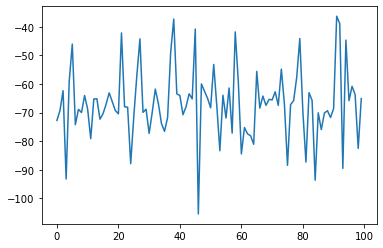

In [8]:
import matplotlib.pyplot as plt

a = result["hist_stats"]
b = a["episode_reward"]

plt.plot(b)



In [9]:
episode_data

[{'n': 0,
  'episode_reward_min': -104.15944801994365,
  'episode_reward_mean': -74.16342953198993,
  'episode_reward_max': -44.29764357780588,
  'episode_len_mean': 101.0},
 {'n': 1,
  'episode_reward_min': -121.16195954708573,
  'episode_reward_mean': -71.8574517549739,
  'episode_reward_max': -36.293007601338914,
  'episode_len_mean': 101.0},
 {'n': 2,
  'episode_reward_min': -121.16195954708573,
  'episode_reward_mean': -69.1280269839091,
  'episode_reward_max': -36.293007601338914,
  'episode_len_mean': 101.0},
 {'n': 3,
  'episode_reward_min': -121.16195954708573,
  'episode_reward_mean': -69.01784228820527,
  'episode_reward_max': -36.293007601338914,
  'episode_len_mean': 101.0},
 {'n': 4,
  'episode_reward_min': -121.16195954708573,
  'episode_reward_mean': -69.00023566118287,
  'episode_reward_max': -36.293007601338914,
  'episode_len_mean': 101.0},
 {'n': 5,
  'episode_reward_min': -121.16195954708573,
  'episode_reward_mean': -68.40649928614187,
  'episode_reward_max': -36.

In [10]:
episode_data[1]

{'n': 1,
 'episode_reward_min': -121.16195954708573,
 'episode_reward_mean': -71.8574517549739,
 'episode_reward_max': -36.293007601338914,
 'episode_len_mean': 101.0}

In [11]:
rewards_space

[-74.16342953198993,
 -71.8574517549739,
 -69.1280269839091,
 -69.01784228820527,
 -69.00023566118287,
 -68.40649928614187,
 -68.14296795662415,
 -67.06346811174328,
 -67.69651563092536,
 -68.29438668069183,
 -67.51251905994411,
 -67.75484556157036,
 -68.4256972561449,
 -69.39779398027741,
 -68.11766933623122,
 -67.72816474275787,
 -67.78768614164807,
 -67.93204786969395,
 -68.5220582361839,
 -67.78607873276506,
 -68.30671152544224,
 -68.61772951369343,
 -69.22126478682567,
 -68.76919486010914,
 -69.08409990590623,
 -68.47154028525219,
 -68.40457850452079,
 -67.67033351748711,
 -68.04295288474168,
 -67.1523240195088,
 -68.01986239773129,
 -68.11381844059099,
 -67.35976136028644,
 -67.65793280698644,
 -67.72633779518912,
 -67.33452964782171,
 -66.89319806605202,
 -65.93536056065074,
 -66.22494586877399,
 -67.31819644475742,
 -67.17156906544234,
 -66.53269850865007,
 -66.65564622171145,
 -66.27437607944127,
 -66.50540548552024,
 -66.87663799326073,
 -66.30909083829165,
 -66.1815325283998

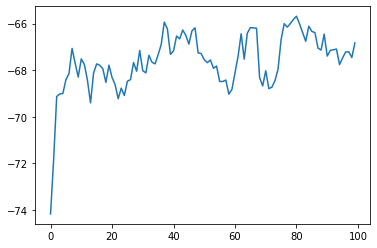

In [12]:
plt.plot(rewards_space)

In [13]:
# Test paramaters
env_name = "GyroscopeEnv-v1"

# init_state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
env = create_env(env_name,state=None)

agent_paths = ['ddpg_q_i0','ddpg_q_i001','ddpg_q_i01','ddpg_q_i1']

agent.restore(checkpoint_path)

agent = load_agent(agent_paths[0])
t_end = 10

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

NameError: name 'create_env' is not defined